<a href="https://colab.research.google.com/github/ehsanbarkhordar/Clustering-of-Bank-Customers/blob/main/clustering_of_bank_customers_using_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [3]:
!pip install scikit-learn-extra
!pip install kneed
!pip install fuzzy-c-means
!pip install dtaidistance
!pip install pyclustering

In [4]:
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.advanced_activations import PReLU, LeakyReLU

from tensorflow import feature_column, keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers

from keras.layers import Dense, LSTM, GRU, dot, Input, Embedding, \
 TimeDistributed, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA,TruncatedSVD,KernelPCA
from sklearn.manifold import TSNE,MDS,Isomap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from sklearn.metrics import davies_bouldin_score 
from sklearn_extra.cluster import KMedoids
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import LocallyLinearEmbedding
from dtaidistance import dtw, clustering
from mpl_toolkits.mplot3d import Axes3D
from numpy import unique
from numpy import where
from kneed import KneeLocator
from os import listdir
from os.path import isfile, join
from random import randrange
from tqdm import tqdm

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import datetime
import plotly.express as px
import plotly.graph_objects as go

In [5]:
my_drive_path = '/content/gdrive/MyDrive/'
dataset_path = my_drive_path + '/lpetrocelli-retail-banking-demo-data/'
onlyfiles = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]
onlyfiles

['CRM Call Center Logs.csv',
 'CRM Events.csv',
 'completedcard.csv',
 'LuxuryLoanPortfolio.csv',
 'completedorder.csv',
 'completedloan.csv',
 'completedclient.csv',
 'completedacct.csv',
 'completedtrans.csv',
 'completeddistrict.csv',
 'CRM Reviews.csv',
 'completeddisposition.csv',
 'completedclient_edited.csv']

In [6]:
# Import Clients
df_clients_origin = pd.read_csv(dataset_path+'completedclient_edited.csv', index_col=[0], low_memory=False)
# Import Transactions
df_transactions_origin = pd.read_csv(dataset_path+'completedtrans.csv', index_col=[0], low_memory=False)
# Import Positions
df_positions_origin = pd.read_csv(dataset_path+'completeddisposition.csv', index_col=[0], low_memory=False)

In [7]:
# Convert city to latitude and longitude

# from geopy import geocoders
# cities_list = list(df_clients_origin['city'].unique())
# cities_dict = {}
# for c in tqdm(cities_list):
#   gn = geocoders.GeoNames(username='barkhordar',timeout=10)
#   location = gn.geocode(c)
#   cities_dict[c] = [location.latitude , location.longitude]

In [8]:
df_clients = df_clients_origin.join(df_positions_origin.set_index('client_id'), on='client_id')
df_clients

,sex,fulldate,day,month,year,age,social,first,middle,last,phone,email,address_1,address_2,city,state,zipcode,district_id,latitude,longitude,account_id,type
client_id,,,,,,,,,,,,,,,,,,,,,,
C00000001,Female,1990-12-13,13,12,1990,29,926-93-2157,Emma,Avaya,Smith,367-171-6840,emma.smith@gmail.com,387 Wellington Ave.,Unit 1,Albuquerque,NM,47246,18,35.08449,-106.65114,A00000001,Owner
C00000002,Male,1965-02-04,4,2,1965,54,806-94-5725,Noah,Everest,Thompson,212-423-7734,noah.thompson@gmail.com,75 W. Berkshire St.,NaN,New York City,NY,10040,1,40.71427,-74.00597,A00000002,Owner
C00000003,Female,1960-10-09,9,10,1960,59,614-70-9100,Olivia,Brooklynne,Johnson,212-425-6932,olivia.johnson@outlook.com,36 Second St.,NaN,New York City,NY,10162,1,40.71427,-74.00597,A00000002,User
C00000004,Male,1976-12-01,1,12,1976,43,580-20-3414,Liam,Irvin,White,951-567-8925,liam.white@gmail.com,7607 Sunnyslope Street,NaN,Indianapolis,IN,49047,5,39.76838,-86.15804,A00000003,Owner
C00000005,Female,1980-07-03,3,7,1980,39,536-14-5809,Sophia,Danae,Williams,428-265-1568,sophia.williams@gmail.com,755 Galvin Street,NaN,Indianapolis,IN,40852,5,39.76838,-86.15804,A00000003,User
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C00013955,Female,1965-10-30,30,10,1965,54,830-38-3530,Adrianna,Jillian,Moore,212-205-7422,adrianna.moore@outlook.com,9405 SW. Leeton Ridge Drive,NaN,New York City,NY,10121,1,40.71427,-74.00597,A00011349,Owner
C00013956,Male,1963-04-06,6,4,1963,56,773-25-4409,Aaron,Roman,Park,212-645-8820,aaron.park@gmail.com,7021 Chapel Ave.,NaN,New York City,NY,10118,1,40.71427,-74.00597,A00011349,User
C00013968,Male,1988-04-13,13,4,1988,31,227-17-0778,Eli,Leonardo,Warner,508-465-5164,eli.warner@hotmail.com,43 Edgemont Dr.,NaN,Fall River,MA,2721,61,41.70149,-71.15505,A00011359,Owner


In [9]:
df_clients[['account_id','sex','age','city']]

,account_id,sex,age,city
client_id,,,,
C00000001,A00000001,Female,29,Albuquerque
C00000002,A00000002,Male,54,New York City
C00000003,A00000002,Female,59,New York City
C00000004,A00000003,Male,43,Indianapolis
C00000005,A00000003,Female,39,Indianapolis
...,...,...,...,...
C00013955,A00011349,Female,54,New York City
C00013956,A00011349,Male,56,New York City
C00013968,A00011359,Male,31,Fall River


In [10]:
df_clients_onehot = pd.DataFrame()
df_clients_onehot['account_id']=df_clients['account_id']

In [11]:
sex_dict = {'Male':1.0,'Female':0.0}
df_clients_onehot['sex'] = df_clients['sex'].apply(lambda x: sex_dict.get(x))
df_clients_onehot["age"] = df_clients['age']

In [12]:
df_clients_onehot["latitude"] = df_clients["latitude"]
df_clients_onehot["longitude"] = df_clients["longitude"]

In [13]:
df_clients_onehot

,account_id,sex,age,latitude,longitude
client_id,,,,,
C00000001,A00000001,0.0,29,35.08449,-106.65114
C00000002,A00000002,1.0,54,40.71427,-74.00597
C00000003,A00000002,0.0,59,40.71427,-74.00597
C00000004,A00000003,1.0,43,39.76838,-86.15804
C00000005,A00000003,0.0,39,39.76838,-86.15804
...,...,...,...,...,...
C00013955,A00011349,0.0,54,40.71427,-74.00597
C00013956,A00011349,1.0,56,40.71427,-74.00597
C00013968,A00011359,1.0,31,41.70149,-71.15505


In [14]:
df = df_clients_onehot
df = df [['sex','latitude','longitude','age']]
df_clients_normalized=(df-df.mean())/df.std()
df_clients_normalized['account_id']=df_clients_onehot['account_id']
df_clients_normalized

,sex,latitude,longitude,age,account_id
client_id,,,,,
C00000001,-1.014729,-0.163898,-0.646533,-0.977190,A00000001
C00000002,0.985301,0.249069,0.091451,0.468980,A00000002
C00000003,-1.014729,0.249069,0.091451,0.758214,A00000002
C00000004,0.985301,0.179684,-0.183262,-0.167334,A00000003
C00000005,-1.014729,0.179684,-0.183262,-0.398722,A00000003
...,...,...,...,...,...
C00013955,-1.014729,0.249069,0.091451,0.468980,A00011349
C00013956,0.985301,0.249069,0.091451,0.584674,A00011349
C00013968,0.985301,0.321486,0.155899,-0.861496,A00011359


In [15]:
# Convert date to python datetime
df_transactions = df_transactions_origin
df_transactions['fulldate'] = pd.to_datetime(df_transactions['fulldate'],format="%Y-%m-%d")
df_transactions['timestamp'] = df_transactions.fulldate.values.astype(np.int64) // 10 ** 9
df_transactions

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day,fulldate,fulltime,fulldatewithtime,timestamp
1,T00695247,A00002378,Credit,Credit in Cash,700.0,700.0,NaN,NaN,NaN,2013,1,1,2013-01-01,11:02:40,2013-01-01T11:02:40,1356998400
2,T00171812,A00000576,Credit,Credit in Cash,900.0,900.0,NaN,NaN,NaN,2013,1,1,2013-01-01,08:23:33,2013-01-01T08:23:33,1356998400
3,T00207264,A00000704,Credit,Credit in Cash,1000.0,1000.0,NaN,NaN,NaN,2013,1,1,2013-01-01,15:19:21,2013-01-01T15:19:21,1356998400
4,T01117247,A00003818,Credit,Credit in Cash,600.0,600.0,NaN,NaN,NaN,2013,1,1,2013-01-01,10:42:35,2013-01-01T10:42:35,1356998400
5,T00579373,A00001972,Credit,Credit in Cash,400.0,400.0,NaN,NaN,NaN,2013,1,2,2013-01-02,11:39:25,2013-01-02T11:39:25,1357084800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056316,T03626622,A00002906,Credit,NaN,62.3,13729.4,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,15:18:14,2018-12-31T15:18:14,1546214400
1056317,T03627616,A00002935,Credit,NaN,81.3,19544.9,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,13:04:60,2018-12-31T13:04:60,1546214400
1056318,T03625403,A00002869,Credit,NaN,60.2,14638.2,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,08:30:13,2018-12-31T08:30:13,1546214400
1056319,T03626683,A00002907,Credit,NaN,107.5,23453.0,Interest Credited,NaN,NaN,2018,12,31,2018-12-31,14:45:19,2018-12-31T14:45:19,1546214400


In [16]:
df_transactions = df_transactions.set_index('trans_id')
df_transactions = df_transactions [['account_id','type','amount','balance','timestamp']]
df_transactions = df_transactions.sort_values('timestamp')
df_transactions

,account_id,type,amount,balance,timestamp
trans_id,,,,,
T00695247,A00002378,Credit,700.0,700.0,1356998400
T00171812,A00000576,Credit,900.0,900.0,1356998400
T00207264,A00000704,Credit,1000.0,1000.0,1356998400
T01117247,A00003818,Credit,600.0,600.0,1356998400
T00579373,A00001972,Credit,400.0,400.0,1357084800
...,...,...,...,...,...
T03629556,A00002990,Credit,175.0,42712.1,1546214400
T03630422,A00003025,Credit,73.9,15933.6,1546214400
T03631495,A00003053,Credit,349.8,86982.1,1546214400


In [17]:
transaction_type_dict = {'Debit':1.0,'Credit':0.0}
df_transactions['type'] = df_transactions['type'].apply(lambda x: transaction_type_dict.get(x))
df_transactions

,account_id,type,amount,balance,timestamp
trans_id,,,,,
T00695247,A00002378,0.0,700.0,700.0,1356998400
T00171812,A00000576,0.0,900.0,900.0,1356998400
T00207264,A00000704,0.0,1000.0,1000.0,1356998400
T01117247,A00003818,0.0,600.0,600.0,1356998400
T00579373,A00001972,0.0,400.0,400.0,1357084800
...,...,...,...,...,...
T03629556,A00002990,0.0,175.0,42712.1,1546214400
T03630422,A00003025,0.0,73.9,15933.6,1546214400
T03631495,A00003053,0.0,349.8,86982.1,1546214400


In [18]:
df = df_transactions
df = df [['type','amount','balance','timestamp']]
df_transactions_normalized=(df-df.mean())/df.std()
df_transactions_normalized['account_id']=df_transactions['account_id']
df_transactions_normalized

,type,amount,balance,timestamp,account_id
trans_id,,,,,
T00695247,-1.267936,-0.548597,-1.709854,-2.860870,A00002378
T00171812,-1.267936,-0.527595,-1.700812,-2.860870,A00000576
T00207264,-1.267936,-0.517094,-1.696291,-2.860870,A00000704
T01117247,-1.267936,-0.559098,-1.714375,-2.860870,A00003818
T00579373,-1.267936,-0.580101,-1.723418,-2.858917,A00001972
...,...,...,...,...,...
T03629556,-1.267936,-0.603728,0.189610,1.417798,A00002990
T03630422,-1.267936,-0.614345,-1.021108,1.417798,A00003025
T03631495,-1.267936,-0.585372,2.191159,1.417798,A00003053


In [19]:
df_account_grouped = df_transactions_normalized.groupby(['account_id'])
df_account_grouped.size()

account_id
A00000001    239
A00000002    478
A00000003    117
A00000004    186
A00000005     84
            ... 
A00011333    368
A00011349    304
A00011359    378
A00011362    344
A00011382    253
Length: 4500, dtype: int64

In [20]:
max_length_of_transaction = df_account_grouped['amount'].count().max()
print("max trans lenght is: ", max_length_of_transaction)

max trans lenght is:  675


In [21]:
df_account_grouped.get_group('A00000001')

,type,amount,balance,timestamp,account_id
trans_id,,,,,
T00000001,-1.267936,-0.517094,-1.696291,-1.274442,A00000001
T00000005,-1.267936,-0.235767,-1.529954,-1.235367,A00000001
T00000199,-1.267936,0.701044,-0.960279,-1.215830,A00000001
T03530438,-1.267936,-0.620089,-0.959411,-1.202154,A00000001
T00000006,-1.267936,-0.235767,-0.793075,-1.176755,A00000001
...,...,...,...,...,...
T03530481,-1.267936,-0.615059,-0.986389,1.357232,A00000001
T00000230,0.788683,-0.149552,-1.190505,1.363094,A00000001
T00000097,0.788683,-0.364616,-1.301366,1.367001,A00000001


In [22]:
sequence_input_list = []
sequence_output_list = []
for k, v in df_account_grouped:
  user_trans_array = pd.concat([v.type,v.amount,v.balance, v.timestamp], axis=1).values
  array = user_trans_array.copy()
  # add start and end to sequence of transations
  add_start_to_array = np.insert(array, 0, [-1, -1,-1, -1], axis=0)
  input_array = np.append(add_start_to_array, [[-2, -2,-2, -2]], axis=0)
  output_array = np.append(array, [[-2, -2,-2, -2]], axis=0)
  # resize array to max_lenght
  input_array.resize((max_length_of_transaction,4), refcheck=False)
  output_array.resize((max_length_of_transaction,4), refcheck=False)
  # append them to list
  sequence_input_list.append(input_array)
  sequence_output_list.append(output_array)

In [23]:
sequence_input_array = np.array(sequence_input_list)
sequence_output_input_array = sequence_input_array
sequence_output_array = np.array(sequence_output_list)
sequence_output_array.shape

(4500, 675, 4)

In [24]:
(sequence_output_input_array == sequence_output_array).all()

False

In [25]:
# Build static input array
list_of_account_ids = list(df_account_grouped.groups.keys())
static_input_list = []
for account_id in list_of_account_ids:
  sub_df = df_clients_normalized.loc[df_clients_normalized['account_id'] == account_id]
  sub_df = sub_df.iloc[0]
  account_static_vector = sub_df[['sex','age','latitude','longitude']].values.tolist()
  static_input_list.append(account_static_vector)
static_input_array = np.array(static_input_list)
print(static_input_array.shape)
static_output_array = static_input_array
static_input_array

(4500, 4)


array([[-1.01472945, -0.9771898 , -0.1638979 , -0.6465329 ],
       [ 0.98530081,  0.46898042,  0.24906924,  0.0914507 ],
       [ 0.98530081, -0.16733447,  0.17968438, -0.18326156],
       ...,
       [ 0.98530081, -0.86149618,  0.32148583,  0.1558992 ],
       [-1.01472945, -0.51441533,  0.29899034,  0.10392843],
       [-1.01472945,  0.00620595,  0.33238184, -0.21699025]])

In [26]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.67.84.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.84.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [58]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  }

def elbow_method(X):
  # A list holds the SSE values for each k
  sse = []
  for k in range(1, 11):
      kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
      kmeans.fit(X)
      sse.append(kmeans.inertia_)
  plt.style.use("fivethirtyeight")
  plt.plot(range(1, 11), sse)
  plt.xticks(range(1, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()
  kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
  print("Optimum number of clusters is: ", kl.elbow)
  return int(kl.elbow)

def plot_clustering(X, labels, centers):
  if X.shape[1] == 3:
    df = pd.DataFrame({'feature1':X[:, 0],'feature2':X[:, 1],'feature3':X[:, 2],'labels':labels})
    fig = go.Figure(data=go.Scatter3d(
        x = df['feature1'],
        y = df['feature2'],
        z = df['feature3'],
        mode='markers',
        marker=dict(
            color=df['labels'],
            colorscale='Viridis',
            line_width=1
        )
    ))
    fig.update_layout(
        xaxis_title="1st principal component",
        yaxis_title="2nd principal component",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple",
        ),
        title={
          'text': "Plot Customer Clustering",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'}
        
    )
    fig.show()
  else:
    df = pd.DataFrame({'feature1':X[:, 0],'feature2':X[:, 1],'labels':labels})
    fig = go.Figure(data=go.Scattergl(
        x = df['feature1'],
        y = df['feature2'],
        mode='markers',
        marker=dict(
            color=df['labels'],
            colorscale='Viridis',
            line_width=1
        )
    ))
    fig.update_layout(
        xaxis_title="1st principal component",
        yaxis_title="2nd principal component",
        font=dict(
            family="Courier New, monospace",
            size=18,
            color="RebeccaPurple",
        ),
        title={
          'text': "Plot Customer Clustering",
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'}
        
    )
    fig.show()

def do_kmeans(X, n_clusters,):
  kmeans = KMeans(n_clusters = n_clusters, **kmeans_kwargs)
  kmeans.fit(X)
  print(set(kmeans.labels_))

  silhouette_avg = silhouette_score(X, kmeans.labels_)
  print("Silhouette: ", silhouette_avg , " The best value is 1 and the worst value is -1.")

  print("Davies–Bouldin index: ", davies_bouldin_score(X, kmeans.labels_), " lower values indicating better clustering.")

  plot_clustering(X, kmeans.labels_, kmeans.cluster_centers_)

In [28]:
def create_model():
  latent_dim = 16
  decoder_dim = 4
  num_dynamic_features = 4
  ###########################################  encoder  ###########################################

  # Sequence input shape is N*2 which N is sequence length and 2 is price and time
  sequence_input = Input(name='sequence_input', shape=(None, num_dynamic_features))

  # Many_to_one_lstm
  outputs  = LSTM(64, return_sequences=True)(sequence_input)
  # outputs = GRU(2048, return_sequences=True)(outputs)
  # outputs = Dropout(0.2, input_shape=(2,))(outputs)
  encoder_out , hidden_state, cell_state = LSTM(latent_dim, return_state=True, return_sequences=True)(outputs)

  latent_space = Concatenate()([hidden_state, cell_state])
  #Layer below output can be used for clustering purposes
  latent_space = Dense(latent_dim, activation = 'relu', name='latent_space')(latent_space)

  ###########################################  /encoder  ###########################################

  ###########################################  decoder  ###########################################

  # Temporary input with a time step delay for producing sequence output
  # This input is exacly similar to sequence_input with only this diffrence that has a time step delay
  sequence_output_input = Input(name='sequence_output_input', shape=(None, num_dynamic_features))

  # One to many GRU (because of its simplicity, we used GRU instead of LSTM)
  decoder_out = GRU(latent_dim, return_sequences=True)(sequence_output_input, initial_state = latent_space)
  ###########################################  attention  ###########################################
  # attention = dot([decoder_out, encoder_out], axes=[2, 2])
  # attention = Activation('softmax')(attention)
  # context = dot([attention, encoder_out], axes=[2,1])
  # decoder_combined_context = Concatenate()([context, decoder_out])
  ###########################################  /attention  ###########################################

  decoder_outputs = TimeDistributed(Dense(decoder_dim, activation='sigmoid'),name='decoder_outputs')(decoder_out)

  ###########################################  /decoder  ###########################################

  # Model has three inputs and 2 outputs (last input is temorary)
  model = Model(inputs = [sequence_input, sequence_output_input],
              outputs = [decoder_outputs])

  return model

In [29]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MSE)
  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 64)     17664       sequence_input[0][0]             
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 16), ( 5184        lstm[0][0]                       
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32)           0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                 

In [30]:
batch_size = 512
inputs = [sequence_input_array, sequence_output_input_array]
outputs = [sequence_output_array]

training_history = model.fit(inputs, outputs,
                             epochs=20,
                             batch_size = batch_size,
                             validation_split=0.1)

Epoch 1/20
8/8 [==============================] - 20s 1s/step - loss: 0.5766 - val_loss: 0.7126
Epoch 2/20
8/8 [==============================] - 3s 379ms/step - loss: 0.5640 - val_loss: 0.6993
Epoch 3/20
8/8 [==============================] - 3s 384ms/step - loss: 0.5511 - val_loss: 0.6855
Epoch 4/20
8/8 [==============================] - 3s 380ms/step - loss: 0.5365 - val_loss: 0.6685
Epoch 5/20
8/8 [==============================] - 3s 381ms/step - loss: 0.5088 - val_loss: 0.6162
Epoch 6/20
8/8 [==============================] - 3s 387ms/step - loss: 0.3526 - val_loss: 0.5521
Epoch 7/20
8/8 [==============================] - 3s 383ms/step - loss: 0.3354 - val_loss: 0.5521
Epoch 8/20
8/8 [==============================] - 3s 380ms/step - loss: 0.3317 - val_loss: 0.5511
Epoch 9/20
8/8 [==============================] - 3s 376ms/step - loss: 0.3317 - val_loss: 0.5511
Epoch 10/20
8/8 [==============================] - 3s 380ms/step - loss: 0.3317 - val_loss: 0.5511
Epoch 11/20
8/8 [====

Average test loss:  0.3869


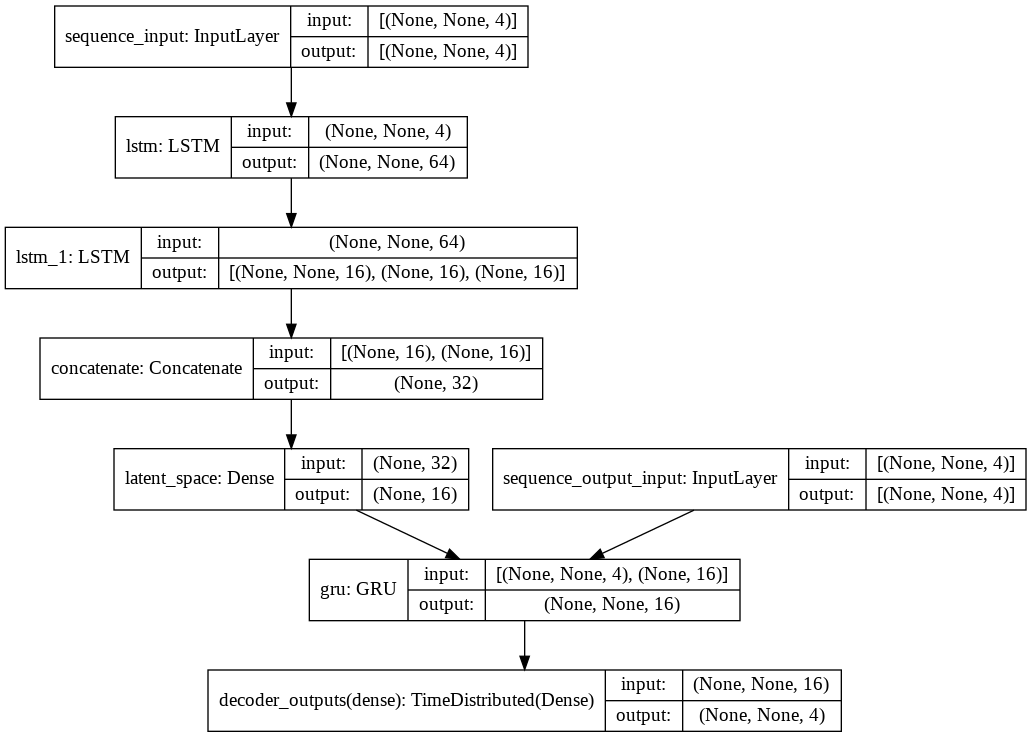

In [31]:
average_loss = np.average(training_history.history['loss'])
print("Average test loss: ", round(average_loss , 4))
plot_model(model, show_shapes=True, show_layer_names=True)

In [32]:
# plot_model(model, show_shapes=True, show_layer_names=True)
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# save the model to disk
# model.save(my_drive_path)
# load model
# model = keras.models.load_model(my_drive_path)

In [34]:
encoder = Model(model.input, model.get_layer("latent_space").output)
predictions = encoder.predict(inputs, batch_size = batch_size,verbose=1)

9/9 [==============================] - 8s 839ms/step


In [73]:
# opt_cluster_numbers = elbow_method(predictions)
opt_cluster_numbers = 3
n_components = 2

In [62]:
# Dynamic time warping
distance_matrix = np.load(my_drive_path + 'distance_matrix3.npy')

sc = StandardScaler()
standard_distance_matrix = sc.fit_transform(distance_matrix)
pca = PCA(n_components=n_components)
X_distance_matrix_pca = pca.fit_transform(standard_distance_matrix)


do_kmeans(X_distance_matrix_pca, opt_cluster_numbers)

{0, 1, 2}
Silhouette:  0.5594483165413539  The best value is 1 and the worst value is -1.
Davies–Bouldin index:  0.6012193839401972  lower values indicating better clustering.


In [70]:
# clustering with encoder-decoder LSTM features

sc = StandardScaler()
standard_predictions = sc.fit_transform(predictions)
pca = PCA(n_components=n_components)
X_predictions_pca = pca.fit_transform(standard_predictions)

do_kmeans(X_predictions_pca, opt_cluster_numbers)

{0, 1, 2}
Silhouette:  0.85823977  The best value is 1 and the worst value is -1.
Davies–Bouldin index:  0.5137486603190693  lower values indicating better clustering.


In [74]:
print(distance_matrix.shape)
print(predictions.shape)
print(static_input_array.shape)

sc = StandardScaler()
standard_static = sc.fit_transform(static_input_array)
pca = Isomap(n_components=n_components)
X_standard_static_pca = pca.fit_transform(standard_static)


final_feature_set = np.concatenate((X_distance_matrix_pca,X_standard_static_pca, X_predictions_pca), axis=1)

sc = StandardScaler()
standard_out = sc.fit_transform(final_feature_set)
pca = KernelPCA(n_components=n_components)
X_out_pca = pca.fit_transform(standard_out)


do_kmeans(X_out_pca, opt_cluster_numbers)

(4500, 4500)
(4500, 16)
(4500, 4)
{0, 1, 2}
Silhouette:  0.5355684324251344  The best value is 1 and the worst value is -1.
Davies–Bouldin index:  0.5960629281657724  lower values indicating better clustering.


In [72]:
# n_components = 128

# pca = PCA(n_components=n_components)
# X_dynamic_pca = pca.fit_transform(standard_dynamic)

# tsne = TSNE(n_components=n_components)
# X_dynamic_tsne = tsne.fit_transform(standard_dynamic)

# pca = PCA(n_components=n_components)
# X_distance_matrix_pca = pca.fit_transform(standard_distance_matrix)

# embedding = LocallyLinearEmbedding(n_components=n_components)
# X_distance_matrix_pca = embedding.fit_transform(standard_distance_matrix)


# svd = TruncatedSVD(n_components=n_components, algorithm='randomized')
# X_distance_matrix_pca = svd.fit_transform(standard_distance_matrix)


# tsne = TSNE(n_components=n_components)
# X_distance_matrix_tsne = tsne.fit_transform(standard_distance_matrix)

In [ ]:
# final_feature_set = np.concatenate((standard_dynamic, X_distance_matrix_pca,standard_dynamic), axis=1)

In [ ]:
# final_feature_set

In [ ]:
# print(final_feature_set.shape)
X_scaled = standard_dynamic

In [ ]:
n_components = 2

pca = PCA(n_components=n_components)
X = pca.fit_transform(X_scaled)

# svd = TruncatedSVD(n_components=n_components, algorithm='randomized')
# X = svd.fit_transform(X_scaled)

# kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=15)
# X = kpca.fit_transform(X_scaled)

# tsne = TSNE(n_components=n_components)
# X = tsne.fit_transform(X_scaled)

# mds = MDS(n_components=n_components, metric=True)
# X = mds.fit_transform(X_scaled)

# isomap = Isomap(n_neighbors=5, n_components=n_components, eigen_solver='auto')
# X = isomap.fit_transform(X_scaled)

# embedding = LocallyLinearEmbedding(n_components=n_components)
# X = embedding.fit_transform(X_scaled)


In [ ]:
X.shape

In [ ]:
kmeans = KMeans(n_clusters = opt_cluster_numbers, **kmeans_kwargs)
kmeans.fit(X)
print(set(kmeans.labels_))

silhouette_avg = silhouette_score(X, kmeans.labels_)
print("Silhouette: ", silhouette_avg , " The best value is 1 and the worst value is -1. ")

print("Davies–Bouldin index: ", davies_bouldin_score(X, kmeans.labels_), " lower values indicating better clustering.")

plot_clustering(X, kmeans.labels_, kmeans.cluster_centers_)

In [ ]:
# lstm autoencoder to recreate a timeseries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [ ]:
# define input timeseries
timeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()

timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries

In [ ]:
timesteps = 3
X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)

n_features = 2
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X

In [ ]:
n_features = 4

# define model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
# fit model
model.fit(X, X, epochs=300, batch_size=5, verbose=0)
# demonstrate reconstruction
yhat = model.predict(X, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X, 3))

In [ ]:
encoder = Model(model.input, model.get_layer("repeat_vector_3").output)
predictions = encoder.predict(X, batch_size = 5)

In [ ]:
predictions.shape

In [ ]:
# # rng = np.random.default_rng(seed=42)
# # sequence = rng.random((50, 10,4))
# sequence = np.array([
#     [[0.334, 0.043],[0.423 ,0.065],[0.494 ,0.124]],
#     [[0.39 , 0.072],[0.5,  0.126],[0.592,  0.218]],
#     [[0.469 ,0.121],[0.597 ,0.213],[0.703, 0.345]],
#     [[0.573, 0.201],[0.7 ,  0.339],[0.811, 0.514]],
#     [[0.724, 0.352],[0.798 ,0.515],[0.898 ,0.729]],]
#     )
# n_in = len(sequence)
# # sequence = sequence.reshape((1, n_in, 1))
# sequence.shape

In [ ]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model


# define input sequence
# rng = np.random.default_rng(seed=42)
# sequence = rng.random((50, 10,4))
# sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


# reshape input into [samples, timesteps, features]
# n_in = len(sequence)

sequence = sequence_input_array
n_in = 675
dim_num=4
def get_model_simple():
  # define model
  model = Sequential()
  model.add(LSTM(1024, activation='relu', input_shape=(n_in,dim_num)))
  model.add(RepeatVector(n_in))
  model.add(LSTM(1024, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(dim_num)))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  return model
# model = get_model_simple()
# model.fit(sequence, sequence, epochs=300)
# # connect the encoder LSTM as the output layer
# model = Model(inputs=model.inputs, outputs=model.layers[0].output)
# plot_model(model, show_shapes=True)
# # get the feature vector for the input sequence
# yhat = model.predict(sequence)
# print(yhat.shape)
# print(yhat)

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  model = get_model_simple()
  # model.compile(optimizer=tf.keras.optimizers.Adam(),
  #       loss=tf.keras.losses.MSE)
  model.summary()

In [ ]:
batch_size = 8
training_history = model.fit(sequence, sequence,
                             epochs=5,
                             batch_size = batch_size,
                             validation_split=0.1)

In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
yhat = model.predict(sequence)
print(yhat.shape)
print(yhat)

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
DIAMETER_METHODS = ['mean_cluster', 'farthest']
CLUSTER_DISTANCE_METHODS = ['nearest', 'farthest']


def inter_cluster_distances(labels, distances, method='nearest'):
    """Calculates the distances between the two nearest points of each cluster.
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: `nearest` for the distances between the two nearest points in each cluster, or `farthest`
    """
    if method not in CLUSTER_DISTANCE_METHODS:
        raise ValueError(
            'method must be one of {}'.format(CLUSTER_DISTANCE_METHODS))

    if method == 'nearest':
        return __cluster_distances_by_points(labels, distances)
    elif method == 'farthest':
        return __cluster_distances_by_points(labels, distances, farthest=True)


def __cluster_distances_by_points(labels, distances, farthest=False):
    n_unique_labels = len(np.unique(labels))
    cluster_distances = np.full((n_unique_labels, n_unique_labels),
                                float('inf') if not farthest else 0)

    np.fill_diagonal(cluster_distances, 0)

    for i in np.arange(0, len(labels) - 1):
        for ii in np.arange(i, len(labels)):
            if labels[i] != labels[ii] and (
                (not farthest and
                 distances[i, ii] < cluster_distances[labels[i], labels[ii]])
                    or
                (farthest and
                 distances[i, ii] > cluster_distances[labels[i], labels[ii]])):
                cluster_distances[labels[i], labels[ii]] = cluster_distances[
                    labels[ii], labels[i]] = distances[i, ii]
    return cluster_distances


def diameter(labels, distances, method='farthest'):
    """Calculates cluster diameters
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param method: either `mean_cluster` for the mean distance between all elements in each cluster,
     or `farthest` for the distance between the two points furthest from each other
    """
    if method not in DIAMETER_METHODS:
        raise ValueError('method must be one of {}'.format(DIAMETER_METHODS))

    n_clusters = len(np.unique(labels))
    diameters = np.zeros(n_clusters)

    if method == 'mean_cluster':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii]:
                    diameters[labels[i]] += distances[i, ii]

        for i in range(len(diameters)):
            diameters[i] /= sum(labels == i)

    elif method == 'farthest':
        for i in range(0, len(labels) - 1):
            for ii in range(i + 1, len(labels)):
                if labels[i] == labels[ii] and distances[i, ii] > diameters[
                        labels[i]]:
                    diameters[labels[i]] = distances[i, ii]
    return diameters


def dunn(labels, distances, diameter_method='farthest',
         cdist_method='nearest'):
    """
    Dunn index for cluster validation (larger is better).
    
    .. math:: D = \\min_{i = 1 \\ldots n_c; j = i + 1\ldots n_c} \\left\\lbrace \\frac{d \\left( c_i,c_j \\right)}{\\max_{k = 1 \\ldots n_c}
     \\left(diam \\left(c_k \\right) \\right)} \\right\\rbrace
    
    where :math:`d(c_i,c_j)` represents the distance between
    clusters :math:`c_i` and :math:`c_j`, and :math:`diam(c_k)` is the diameter of cluster :math:`c_k`.
    Inter-cluster distance can be defined in many ways, such as the distance between cluster centroids or between their closest elements.
     Cluster diameter can be defined as the mean distance between all elements in the cluster, between all elements to the cluster centroid,
      or as the distance between the two furthest elements.
    The higher the value of the resulting Dunn index, the better the clustering
    result is considered, since higher values indicate that clusters are
    compact (small :math:`diam(c_k)`) and far apart (large :math:`d \\left( c_i,c_j \\right)`).
    :param labels: a list containing cluster labels for each of the n elements
    :param distances: an n x n numpy.array containing the pairwise distances between elements
    :param diameter_method: see :py:function:`diameter` `method` parameter
    :param cdist_method: see :py:function:`diameter` `method` parameter
    
    .. [Kovacs2005] Kovács, F., Legány, C., & Babos, A. (2005). Cluster validity measurement techniques. 6th International Symposium of
     Hungarian Researchers on Computational Intelligence.
    """

    labels = LabelEncoder().fit(labels).transform(labels)

    ic_distances = inter_cluster_distances(labels, distances, cdist_method)
    min_distance = min(ic_distances[ic_distances.nonzero()])
    max_diameter = max(diameter(labels, distances, diameter_method))

    return min_distance / max_diameter


In [ ]:
print("Optimal number of clusters:", opt_cluster_numbers)

kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
}
kmeans = KMeans(n_clusters = opt_cluster_numbers, **kmeans_kwargs)
kmeans.fit(X)
labels = kmeans.labels_

print("K-means")
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

print("##################################################")

kmedoids = KMedoids(n_clusters = opt_cluster_numbers, random_state=0)
kmedoids.fit(X)
labels = kmedoids.labels_

print("K-medoids")
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
distance_matrices = pairwise_distances(X)
dunk = dunn(labels, distance_matrices)
print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)


In [ ]:
# non_outiler_x = []
# non_outiler_labels = []
# for i in range(len(dbscan_yhat)):
#   c_label = dbscan_yhat[i]
#   if c_label != -1:
#     non_outiler_x.append(X[i])
#     non_outiler_labels.append(c_label)
# non_outiler_labels = np.array(non_outiler_labels)
# non_outiler_x = np.array(non_outiler_x)

In [ ]:
# dbscan clustering
# define the model
dbscan_model = DBSCAN(eps=.19, min_samples=15)
# fit model and predict clusters
dbscan_yhat = dbscan_model.fit_predict(X)
# retrieve unique clusters
clusters = unique(dbscan_yhat)
fig = plt.figure(figsize=(15,15))
plt.xlabel('xlabel',fontdict=dict(weight='bold'))
plt.xlabel('1th principal component',fontsize=18)
plt.ylabel('xlabel',fontdict=dict(weight='bold'))
plt.ylabel('2th principal component',fontsize=18)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(dbscan_yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [ ]:
len(set(dbscan_yhat))

In [ ]:
labels = dbscan_yhat
print("DBSCAN")
print('eps: ', dbscan_model.eps)
print('min_samples: ', dbscan_model.min_samples)

print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
# distance_matrices = pairwise_distances(X)
# dunk = dunn(labels, distance_matrices)
# print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

In [ ]:
# optics clustering
# define the model
optics_model = OPTICS(xi=.001,min_cluster_size=20)
# fit model and predict clusters
optics_yhat = optics_model.fit_predict(X)
# retrieve unique clusters
clusters = unique(optics_yhat)
# create scatter plot for samples from each cluster
fig = plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(optics_yhat == cluster)
	# create scatter of these samples
  
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
plt.show()

In [ ]:
len(set(optics_yhat))

In [ ]:
labels = optics_yhat
print("OPTICS")
print('eps: ', optics_model.xi)
print('min_samples: ', optics_model.min_samples)

print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
# distance_matrices = pairwise_distances(X)
# dunk = dunn(labels, distance_matrices)
# print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

In [ ]:
# affinity propagation clustering
# define the model
affinity_propagation_model = AffinityPropagation(damping = 0.92)
# fit the model
affinity_propagation_model.fit(X)
# assign a cluster to each example
affinity_yhat = affinity_propagation_model.predict(X)
# retrieve unique clusters
clusters = unique(affinity_yhat)
# create scatter plot for samples from each cluster
fig = plt.figure(figsize=(15,15))
for cluster in clusters:
	# get row indexes for samples with this cluster
  row_ix = where(affinity_yhat == cluster)
  # create scatter of these samples
  plt.scatter(X[row_ix, 0], X[row_ix, 1])
  plt.xlabel('xlabel',fontdict=dict(weight='bold'))
  plt.xlabel('1th principal component',fontsize=18)
  plt.ylabel('xlabel',fontdict=dict(weight='bold'))
  plt.ylabel('2th principal component',fontsize=18)
# show the plot
plt.show()

In [ ]:
print(len(set(affinity_yhat)))

In [ ]:
labels = affinity_yhat
print("AffinityPropagation")
print('damping: ', affinity_propagation_model.damping)
print("Davies–Bouldin index: ", davies_bouldin_score(X, labels))
# distance_matrices = pairwise_distances(X)
# dunk = dunn(labels, distance_matrices)
# print("Dunn index: ", round(dunk, 6))
silhouette_avg = silhouette_score(X, labels)
print("Silhouette: ", silhouette_avg)

In [ ]:
%matplotlib inline
import numpy as np
from fcmeans import FCM
from matplotlib import pyplot as plt
fcm = FCM(n_clusters = opt_cluster_numbers)
fcm.fit(X)
# outputs
fcm_centers = fcm.centers
fcm_labels = fcm.predict(X)

# plot result
f, axes = plt.subplots(1, 2, figsize=(11,5))
plt.xlabel('xlabel',fontdict=dict(weight='bold'))
plt.xlabel('1th principal component',fontsize=12)
plt.ylabel('xlabel',fontdict=dict(weight='bold'))
plt.ylabel('2th principal component',fontsize=12)
axes[0].scatter(X[:,0], X[:,1], alpha=.1)
axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.show()
pc = fcm.partition_coefficient
pec = fcm.partition_entropy_coefficient
print('partition_coefficient: ',pc)
print('partition_entropy_coefficient: ',pec)

In [ ]:
print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [(principal_components, None)]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters = opt_cluster_numbers)
    ward = cluster.AgglomerativeClustering(n_clusters = opt_cluster_numbers, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters = opt_cluster_numbers,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.1)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters = opt_cluster_numbers,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters = opt_cluster_numbers)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=11)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 5, **kmeans_kwargs)
kmeans.fit(X)
print(set(kmeans.labels_))
print(kmeans.labels_)

In [ ]:
cluster_dict_indx = {}
for c in range(opt_cluster_numbers):
  cluster_dict_indx [c] = [i for i, e in enumerate(kmeans.labels_) if e == c]

In [ ]:
selected_accounts_idx = []
for i in  cluster_dict_indx.keys():
  len_of_cluster = len(cluster_dict_indx[i])
  random_acc_indx = randrange(len_of_cluster)
  selected_accounts_idx.append(cluster_dict_indx[i][random_acc_indx])

In [ ]:
account_ids_list = list(df_account_grouped.groups.keys())
selected_accounts = []
for idx in selected_accounts_idx:
  selected_accounts.append(account_ids_list[idx])

In [ ]:
selected_accounts

In [ ]:
df_selected_accounts = df_trans[df_trans['account_id'].isin(selected_accounts)&(df_trans.fulldate.between(
    datetime.datetime(2017,8,10),datetime.datetime(2018,2,10)))]

In [ ]:
df_selected_full_date = df_selected_accounts.set_index('fulldate')

grouped_selected_accounts = df_selected_full_date.groupby(['account_id'])

fig, ax = plt.subplots(figsize=(15,15))
for key, group in grouped_selected_accounts:
    group['amount'].plot(label=key, ax=ax)

plt.legend(loc='best')

plt.show()